## 1.Import libraries
The required libraries for this notebook are pandas, sklearn, numpy and matplotlib.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import imgaug.augmenters as iaa
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern, canny
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, metrics

## 2.1 Edit label.csv data
Add column for binary label: 0 for no tumor, 1 for tumor

In [2]:
df = pd.read_csv('./dataset/label.csv')
df.head()

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor


## 2.2 Add image data
Add image data in the form of an array to the label data and save it in a new pickle file so it does not need to run everytime

In [3]:
def create_binary(df):
    '''
    Inputs
        df: Label data.
        
    Return
        binary: List of binary labels - 0 if no tumor, 1 if tumor.
    '''
    
    binary = []
    for label in df['label']:
        if 'no_tumor' in label:
            binary.append(0)
        else:
            binary.append(1)
    return binary

In [20]:
data_path = './dataset/image'
images = []
for filename in df['file_name']:
    im = imread(os.path.join(data_path, filename), as_gray = True)
    resized_im = resize(im, (128, 64))
    images.append(resized_im)

# Index of images with no_tumor label
noTumor_idx = df.index[df['label']=='no_tumor'].tolist()
# List of images with no_tumor label
images_noTumor = []
for idx in noTumor_idx:
    images_noTumor.append(images[idx])

seq1 = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    )
], random_order=True)

seq2 = iaa.Sequential([
    iaa.Flipud(0.5), # vertical flips
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    )
], random_order=True)

# Quadruple the no_tumor images
images_aug_noTumor1 = seq1(images=images_noTumor)
images_aug_noTumor2 = seq2(images=images_noTumor)

# Concatenate the lists of image pixel data to form a new dataset with augmented images
images_new = images + images_aug_noTumor1 + images_aug_noTumor2

In [21]:
def extract_hog(images_pixelData):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.
        
    Return
       hog_features: A list of HOG features for each image
    '''
    hog_features = []
    for i in range(len(images_pixelData)):
        # Extract Histogram of Oriented Gradients (HOG) for the image
        fd = hog(images_pixelData[i], orientations = 9, pixels_per_cell = (8, 8),
                            cells_per_block = (2, 2), visualize = False, block_norm='L2-Hys')
        hog_features.append(fd)

    return hog_features

if os.path.exists('./dataset/label_taskA_hog.pkl'):
    print('The pickle file for Task A with hog features data already exists')
else:
    data_path = './dataset/image'
    binary = create_binary(df)
    hog_features = extract_hog(images_new)
    
    label_taskA = pd.DataFrame(data = hog_features)
    label_taskA['binary_label'] = binary + [0]*2*len(noTumor_idx) 
    label_taskA.to_pickle("./dataset/label_taskA_hog.pkl")

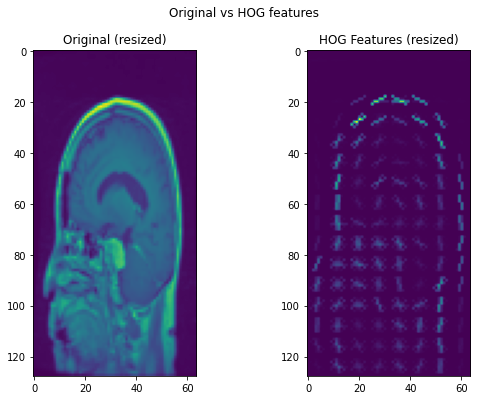

In [6]:
fd, hog_img = hog(images[0], orientations = 9, pixels_per_cell = (8, 8),
                            cells_per_block = (2, 2), visualize = True, block_norm='L2-Hys')

fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
fig.suptitle('Original vs HOG features')
ax1.set_title('Original (resized)')
ax1.imshow(images[0])
ax2.set_title('HOG Features (resized)')
ax2.imshow(hog_img)


In [7]:
def extract_lbp(images_pixelData, radius):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.
        
    Return
       lbp_features: A list of Local Binary Pattern (LBP) features for each image
    '''
    numPoints = 8*radius

    lbp_features = []
    for i in range(len(images_pixelData)):
        # Extract Local Binary Pattern (LBP) for the image
        lbp = local_binary_pattern(images_pixelData[i], numPoints, radius, method="uniform")
        # Create bins for histogram
        n_bins = int(lbp.max() + 1)
        # Create histogram for image
        (hist, _) = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        
        # # normalize the histogram
        # hist = hist.astype("float")
        # hist /= (hist.sum() + eps)
        
        lbp_features.append(hist)
    return lbp_features

if os.path.exists('./dataset/label_taskA_lbp.pkl'):
    print('The pickle file for Task B with lbp features data already exists')
else:
    data_path = './dataset/image'
    classes = create_binary(df)
    lbp_features = extract_lbp(images_new, 3)
    
    label_taskA = pd.DataFrame(data = lbp_features)
    label_taskA['binary_label'] = binary + [0]*len(noTumor_idx)
    label_taskA.to_pickle("./dataset/label_taskA_lbp.pkl")

In [8]:
def extract_canny(images_pixelData, sigma):
    '''
    Inputs
        data_path: Directory path to images in dataset;
        df: Label data.
        
    Return
       canny_features: A list of Local Binary Pattern (LBP) features for each image
    '''
    canny_features = []
    for i in range(len(images_pixelData)):
        # Compute the Canny filter for the image
        filtered_im = canny(images_pixelData[i], sigma=sigma).ravel()
        # filtered_im = filtered_im.ravel()

        canny_features.append(filtered_im)

    return canny_features

if os.path.exists('./dataset/label_taskA_canny.pkl'):
    print('The pickle file for Task B image data filtered with Canny filter already exists')
else:
    data_path = './dataset/image'
    classes = create_binary(df)
    canny_features = extract_canny(images_new, 3)
    
    label_taskA = pd.DataFrame(data = canny_features)
    label_taskA['binary_label'] = binary + [0]*len(noTumor_idx)
    label_taskA.to_pickle("./dataset/label_taskA_canny.pkl")

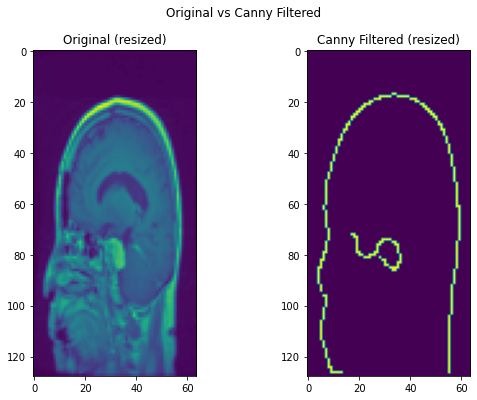

In [9]:
filtered_im = canny(images[0], sigma=3)

fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
fig.suptitle('Original vs Canny Filtered')
ax1.set_title('Original (resized)')
ax1.imshow(images[0])
ax2.set_title('Canny Filtered (resized)')
ax2.imshow(filtered_im)

In [10]:
def PCAPredict(X_train, X_test, k):
    '''
    Inputs
        X_train: Training dataset;
        X_test: Testing dataset;
        k: Number of components to use.
        
    Return
        X_train_PCA: Training dataset after applying PCA to reduce its dimensions;
        X_test_PCA: Test dataset after applying PCA to reduce its dimensions.
    '''

    # the built-in function for PCA
    pca = PCA(k)
    
    # the built-in function to standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()

    # fit the algorithm with dataset
    
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pca.fit(X_train_scaled)
    X_train_PCA = pca.transform(X_train_scaled)
    X_test_PCA = pca.transform(X_test_scaled)
    
    return X_train_PCA, X_test_PCA

In [11]:
def feature_selection(X_train, X_test, y_train):
    # clf = ExtraTreesClassifier(n_estimators=100)
    # clf = clf.fit(X_train, y_train)
    # model = SelectFromModel(clf, prefit=True)
    # X_train_new = model.transform(X_train)
    # X_test_new = model.transform(X_test)

    # forest = RandomForestClassifier(random_state=0)
    # forest.fit(X_train, y_train)
    # model = SelectFromModel(forest, prefit=True)
    # X_train_new = model.transform(X_train)
    # X_test_new = model.transform(X_test)

    lsvc = svm.LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
    model = SelectFromModel(lsvc, prefit=True)
    X_train_new = model.transform(X_train)
    X_test_new = model.transform(X_test)
    
    return X_train_new, X_test_new

In [22]:
feature = 'hog'

if feature == 'hog':
    # Doing classification with image HOG features
    label_taskA = pd.read_pickle("./dataset/label_taskA_hog.pkl")
elif feature == 'lbp':
    # Doing classification with image LBP features
    label_taskA = pd.read_pickle("./dataset/label_taskA_lbp.pkl")
elif feature == 'canny':
    # Doing classification with Canny filtered image data
    label_taskA = pd.read_pickle("./dataset/label_taskA_canny.pkl")
    
X = label_taskA.drop('binary_label',axis=1) # All other features
Y = label_taskA['binary_label'] # binary label

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 3, shuffle=True, stratify=Y) 
#test_size= should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#everytime you run it without specifying random_state, you will get a different result, this is expected behavior
#print (len(X_test), len(y_test))

print('train set: {}  | test set: {}'.format(round(((len(y_train)*1.0)/len(X)),3),
                                                       round((len(y_test)*1.0)/len(X),3)))

# Doing dimensionality reduction with PCA
X_train, X_test = PCAPredict(X_train, X_test, 0.95)
print(f'{X_train.shape[1]} features after PCA')

# Doing feature selection
X_train, X_test = feature_selection(X_train, X_test, y_train)
print(f'{X_train.shape[1]} features left after feature selection')

train set: 0.7  | test set: 0.3
PCA Done. No. of features left = 722
No. of features left = 253 after feature selection


In [23]:
Y.value_counts()

1    2546
0    1362
Name: binary_label, dtype: int64

{'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 1}
KNN classifier score: 0.9599317988064792


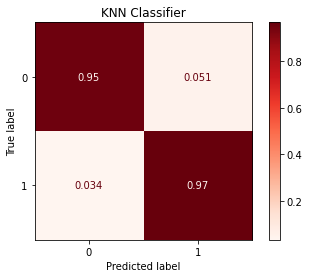

In [24]:
def KNNClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset;
        
    Return
        Y_pred: Predicted labels from X_test using K-Nearest Neighbour.
    '''

    # Create dictionary of parameters to cross validate the estimator on
    parameters = [
    {'algorithm': ['ball_tree'], 'n_neighbors':[1, 2, 3, 4], 'leaf_size':[10, 20, 30]},
    {'algorithm': ['kd_tree'], 'n_neighbors':[1, 2, 3, 4], 'leaf_size':[10, 20, 30]},
    {'algorithm': ['brute'], 'n_neighbors':[1, 2, 3, 4]}
    ]

    # Create KNN object
    neigh = KNeighborsClassifier()
    # Exhaustive search over all chosen parameters
    clf = GridSearchCV(neigh, parameters, scoring='accuracy')
    # Fit KNN model with the parameters for cross-validation
    clf.fit(X_train, y_train) 
    print(clf.best_params_)
    # Predict labels with the best parameters from cross-validation
    Y_pred = clf.predict(X_test)
    
    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Reds,
        normalize='true'
    )
    disp.ax_.set_title('KNN Classifier')
    
    return Y_pred, disp

# clf = svm.SVC()
# clf.fit(X_train, y_train)
# Y_pred = clf.predict(X_test)
# throws error: setting an array element with a sequence
# when getting X from dataframe, the resulting array is dtype object,
# but when getting X directly from hog_features, resulting array is dtype float??

Y_pred_KNN, disp_KNN = KNNClassifierCV(X_train, y_train, X_test)
score_KNN = metrics.accuracy_score(y_test, Y_pred_KNN)
print('KNN classifier score:', score_KNN)

{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 300}
Random Forest classifier score: 0.9276759884281581


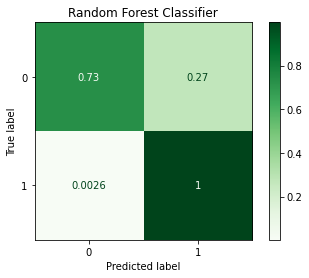

In [15]:
def RFClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset;
        k: Number of trees in the forest.
        
    Return
        Y_pred: Predicted labels from X_test using Random Forests.
    '''
    # Create dictionary of parameters to cross validate the estimator on
    parameters = {'n_estimators':[100, 200, 300], 'criterion':['entropy', 'gini'],
    'max_features': ['sqrt', 'log2']}
    # Create Random Forest object
    RF = RandomForestClassifier()
    # Exhaustive search over all chosen parameters
    clf = GridSearchCV(RF, parameters, scoring='accuracy')
    # Fit RF model with the parameters for cross-validation
    clf.fit(X_train, y_train) 
    print(clf.best_params_)
    # Predict labels with the best parameters from cross-validation
    Y_pred = clf.predict(X_test)

    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Greens,
        normalize='true'
    )
    disp.ax_.set_title('Random Forest Classifier')
    
    return Y_pred, disp

Y_pred_RandomForest, disp_RF = RFClassifierCV(X_train, y_train, X_test)
score_RandomForest = metrics.accuracy_score(y_test, Y_pred_RandomForest)
print('Random Forest classifier score:', score_RandomForest)

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
SVM classifier score: 0.9658994032395567


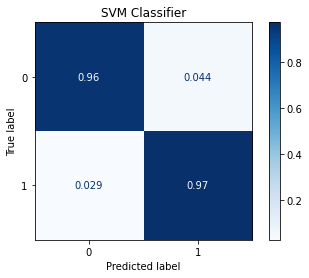

In [25]:
def SVMClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset.
        
    Return
        Y_pred: Predicted labels from X_test using SVM.
    '''

    # Create dictionary of parameters to cross validate the estimator on
    parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4, 1e-5], "C": [1, 10, 100]},
    {"kernel": ["linear"], "C": [1, 10, 100]}
    ]
    # Create SVC object
    svc = svm.SVC()
    # Exhaustive search over all chosen parameters
    clf = GridSearchCV(svc, parameters)
    # Fit SVC model with the parameters for cross-validation
    clf.fit(X_train, y_train)
    # Predict labels with the best parameters from cross-validation
    print(clf.best_params_)
    Y_pred = clf.predict(X_test)

    # classes: List of labels - 0 if no_tumor, 1 if glioma_tumor, 2 if meningioma_tumor, 3 if pituitary_tumor
    disp = metrics.ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize='true'
    )
    disp.ax_.set_title('SVM Classifier')
    
    return Y_pred, disp

Y_pred_SVM, disp_SVM = SVMClassifierCV(X_train, y_train, X_test)
score_SVM = metrics.accuracy_score(y_test, Y_pred_SVM)
print('SVM classifier score:', score_SVM)